In [1]:
import pandas as pd
import numpy as np
import re
#for clustering
from scipy.cluster.hierarchy import fcluster, linkage
#r interface to call fishers exact test
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

##load file names
csv = './Anonymized_644.Updated_cleaned_v1.3.2.tsv'
adjacency_file = './connectivity_646.csv'
adjacency = pd.read_csv(adjacency_file, index_col = 0)
node_list = sorted(adjacency.columns)
node_list

['1A', '1B', '2A', '2B', '3', '4', '5A', '5B', '6', 'RPLN']

In [2]:
#extract all the node names and such
left_nodes = ['L'+n for n in adjacency.columns]
right_nodes = ['R'+n for n in adjacency.columns]
nodes = left_nodes + right_nodes
all_nodes = set(nodes)
node_to_index = {word: position for position, word in enumerate(nodes)}
ambiguous_nodes = set(['2/3','3/4','2/3/4','/3','2/','-R4'])
node_to_index

{'L1A': 0,
 'L1B': 1,
 'L2A': 2,
 'L2B': 3,
 'L3': 4,
 'L4': 5,
 'L5A': 6,
 'L5B': 7,
 'L6': 8,
 'LRPLN': 9,
 'R1A': 10,
 'R1B': 11,
 'R2A': 12,
 'R2B': 13,
 'R3': 14,
 'R4': 15,
 'R5A': 16,
 'R5B': 17,
 'R6': 18,
 'RRPLN': 19}

In [3]:
#helper functions
def parse_lymph_nodes(node_string):
    #the data apparently has just '2' when theres a '2A' and '2B'
    node_string = re.sub('L2,*','L2A, L2B,', node_string)
    node_string = re.sub('R2,*','R2A, R2B,', node_string)
    nodes = [n.strip() for n in node_string.split(',')]
    #remove the node with 'in-between' labeled nodes?
    for n in nodes:
        if n in ambiguous_nodes:
            return np.NaN
    nodes = [n for n in nodes if n in all_nodes]
    return nodes if len(nodes) > 0 else np.NaN

data = pd.read_csv(csv, sep='\t' , index_col=0, 
                   usecols=['Dummy ID', 'Affected Lymph node UPPER','Feeding tube 6m', 'Aspiration rate(Y/N)'],
                   dtype = {'Affected Lymph node UPPER': str}).dropna()
data['Affected Lymph node UPPER'] = data['Affected Lymph node UPPER'].apply(parse_lymph_nodes)
data = data.dropna()
data.describe()

,Affected Lymph node UPPER,Feeding tube 6m,Aspiration rate(Y/N)
count,590,590,590
unique,81,2,2
top,"[R2A, R2B]",N,N
freq,134,488,490


In [4]:
monograms = pd.DataFrame(index = data.index, columns = nodes, dtype = np.int32).fillna(0)
for p in data.itertuples():
    for lymph_node in p._1:
        monograms.loc[p.Index, lymph_node] = 1
monograms.LRPLN[monograms.LRPLN != 0] = -1
monograms.RRPLN[monograms.RRPLN != 0] = -1
monograms.head(5)

,L1A,L1B,L2A,L2B,L3,L4,L5A,L5B,L6,LRPLN,R1A,R1B,R2A,R2B,R3,R4,R5A,R5B,R6,RRPLN
Dummy ID,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
bigram_set = set([])

for i, name in enumerate(node_list):
    for i2 in range(i+1, len(node_list)):
        if adjacency.iloc[i,i2] > 0:
            bigram_set.add(name + node_list[i2])
' '.join(sorted(bigram_set))

'1A1B 1A6 1B2A 1B3 2A2B 2A3 2B5A 34 35A 36 45B 46 5A5B'

In [6]:
def bigramize(v):
    #shoudl take a unilateral (left or right) matrix of affected lypmh nnodes
    assert(v.shape[1] == adjacency.shape[1])
    col_names = list(v.columns)
    clean = lambda x:  re.sub('^[LR]\s*','', x)
    bigrams = []
    for i, colname in enumerate(col_names):
        nodename = clean(colname)
        for i2 in range(i+1, v.shape[1]):
            colname2 = col_names[i2]
            if nodename + clean(colname2) in bigram_set:
                bigram_vector = v[colname].values * v[colname2].values
                bigrams.append(bigram_vector.reshape(-1,1))
    return np.hstack(bigrams)

def drop_empty_rows(x):
    nonempty = np.argwhere(x.std(axis = 0) > 1e-10).ravel()
    return x[:,nonempty]
            
l_bigrams = bigramize(monograms.loc[:, left_nodes])
r_bigrams = bigramize(monograms.loc[:, right_nodes])
v_nonspatial = monograms.loc[:, left_nodes].values + monograms.loc[:, right_nodes].values
v_nonspatial = drop_empty_rows(v_nonspatial)
v_spatial = np.hstack([v_nonspatial, l_bigrams + r_bigrams])
v_spatial = drop_empty_rows(v_spatial)

In [7]:
# check to see values are in [0,2]
for v in [v_nonspatial, v_spatial]:
    assert(v.max() <= 2)
    assert(v.min() >= 0)

In [8]:
#distance functions:
def tanimoto(x,y):
    numerator = x.dot(y)
    denominator = (x.dot(x) + y.dot(y) - x.dot(y))
    if denominator > 0:
        return numerator/denominator
    return 0

def cosine(x,y):
    numerator = x.dot(y)
    denominator = np.linalg.norm(x)*np.linalg.norm(y)
    if denominator > 0:
        return numerator/denominator
    return 0

def jaccard(x,y):
    x = np.nan_to_num(x/x)
    y = np.nan_to_num(y/y)
    return tanimoto(x,y)

def l1(x1, x2):
    return np.sum(np.abs(x1-x2))

def l2(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

def tanimoto_dist(x,y):
    return 1/(1+tanimoto(x,y))

def cosine_dist(x,y):
    return 1/(1+cosine(x,y))

def jaccard_dist(x,y):
    return 1/(1+jaccard(x,y))

#creates the similarity matrix
def similarity(matrix, sim_func):
    n_patients = matrix.shape[0]
    similarities = np.zeros((n_patients, n_patients))
    for p in range(n_patients):
        for p2 in range(p+1, n_patients):
            similarities[p,p2] = sim_func(matrix[p], matrix[p2])
    similarities += similarities.transpose()
    np.fill_diagonal(similarities, 1)
    return similarities


In [23]:
ft = data['Feeding tube 6m'] == 'Y'
aspiration = data['Aspiration rate(Y/N)'] == 'Y'
toxicity = ft | aspiration
toxicities = [ft, aspiration, toxicity]

def get_contingency_table(x, y):
        #assumes x and y are two equal length vectors, creates a mxn contigency table from them
        cols = sorted(list(np.unique(y)))
        rows = sorted(list(np.unique(x)))
        tabel = np.zeros((len(rows), len(cols)))
        for row_index in range(len(rows)):
            row_var = rows[row_index]
            for col_index in range(len(cols)):
                rowset = set(np.argwhere(x == row_var).ravel())
                colset = set(np.argwhere(y == cols[col_index]).ravel())
                tabel[row_index, col_index] = len(rowset & colset)
        return tabel
    
def fisher_exact_test(c_labels, y):
        if len(set(y)) == 1:
            print('fisher test run with no positive class')
            return 0
#        assert(len(set(y)) == 2)
        #call fishers test from r
        contingency = get_contingency_table(c_labels, y)
        stats = importr('stats')
        pval = stats.fisher_test(contingency, workspace = 2e8)[0][0]
        return pval

    
def get_correlation(encoding, dist_func,  n_clusters = 6, criterion = 'maxclust', print_out = True):
    tox_names = ['feeding_tube', 'aspiration', 'either']
    links = linkage(encoding, method = 'weighted', metric = dist_func)
    cluster_labels = fcluster(links, n_clusters, criterion = criterion)
    if print_out:
        for tox in toxicities:
            print(tox_names.pop(0))
            print(fisher_exact_test(cluster_labels, tox))
            print(get_contingency_table(cluster_labels, tox))
            print()
    return links


spatial - tanimto


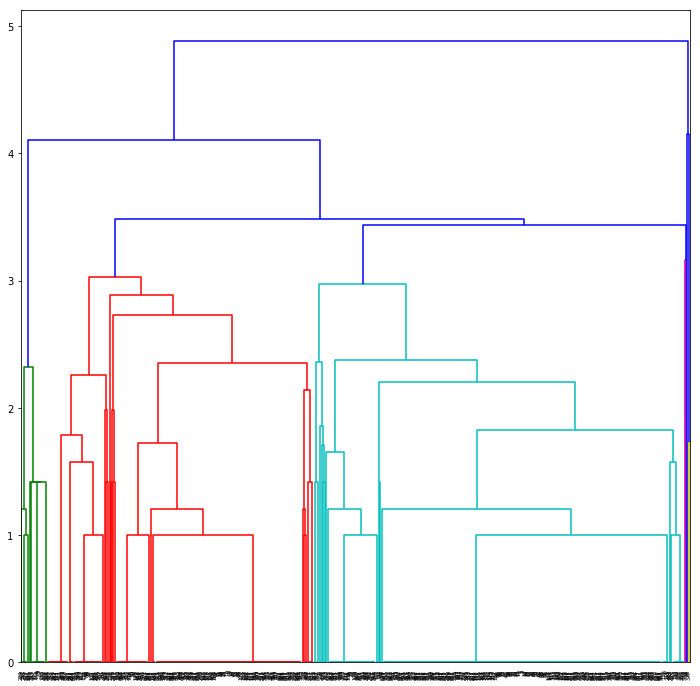

In [28]:
print('spatial - tanimto')
links = get_correlation(v_spatial, l2, 6, print_out = False)
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
plt.figure(figsize=(12,12))
dendrogram(links,
          orientation = 'top',
          distance_sort='descending',
          show_leaf_counts = True)
plt.show()

In [11]:
print('nonspatial - tanimto')
get_correlation(v_nonspatial, tanimoto_dist)
print('nonspatial - cosine')
get_correlation(v_nonspatial, cosine_dist)
print('nonspatial - jaccard')
get_correlation(v_nonspatial, jaccard_dist)
print('nonspatial -l1')
get_correlation(v_nonspatial, l1)
print('nonspatial - l2')
get_correlation(v_nonspatial, l2)

nonspatial - tanimto
[[0.00000000e+00 2.00000000e+00 5.00000000e-01 2.00000000e+00]
 [1.00000000e+00 3.00000000e+00 5.00000000e-01 2.00000000e+00]
 [5.00000000e+00 5.90000000e+02 5.00000000e-01 3.00000000e+00]
 ...
 [1.12900000e+03 1.17400000e+03 9.42887791e-01 5.69000000e+02]
 [1.17500000e+03 1.17600000e+03 9.72604072e-01 5.89000000e+02]
 [5.27000000e+02 1.17700000e+03 9.89476376e-01 5.90000000e+02]]
feeding_tube
0.005137776046298628
[[ 17.   2.]
 [  1.   0.]
 [  1.   1.]
 [234.  31.]
 [234.  68.]
 [  1.   0.]]

aspiration
0.05092683139086235
[[ 18.   1.]
 [  1.   0.]
 [  2.   0.]
 [231.  34.]
 [237.  65.]
 [  1.   0.]]

either
0.014704169135322845
[[ 16.   3.]
 [  1.   0.]
 [  1.   1.]
 [209.  56.]
 [204.  98.]
 [  1.   0.]]

nonspatial - cosine
[[0.00000000e+00 2.00000000e+00 5.00000000e-01 2.00000000e+00]
 [5.00000000e+00 5.90000000e+02 5.00000000e-01 3.00000000e+00]
 [4.00000000e+00 9.00000000e+00 5.00000000e-01 2.00000000e+00]
 ...
 [1.17300000e+03 1.17500000e+03 8.28256166e-01 5

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


[[0.00000000e+00 2.00000000e+00 5.00000000e-01 2.00000000e+00]
 [1.00000000e+00 3.00000000e+00 5.00000000e-01 2.00000000e+00]
 [5.00000000e+00 5.90000000e+02 5.00000000e-01 3.00000000e+00]
 ...
 [1.17400000e+03 1.17500000e+03 9.02904886e-01 5.87000000e+02]
 [1.14500000e+03 1.17600000e+03 9.60770089e-01 5.89000000e+02]
 [5.27000000e+02 1.17700000e+03 9.88662574e-01 5.90000000e+02]]
feeding_tube
0.012275487229610435
[[  1.   1.]
 [197.  57.]
 [271.  42.]
 [ 12.   0.]
 [  6.   2.]
 [  1.   0.]]

aspiration
0.03650613459191567
[[  2.   0.]
 [197.  57.]
 [271.  42.]
 [ 12.   0.]
 [  7.   1.]
 [  1.   0.]]

either
0.010617728014484377
[[  1.   1.]
 [172.  82.]
 [241.  72.]
 [ 12.   0.]
 [  5.   3.]
 [  1.   0.]]

nonspatial -l1
[[0.00000000e+00 2.00000000e+00 0.00000000e+00 2.00000000e+00]
 [1.00000000e+00 3.00000000e+00 0.00000000e+00 2.00000000e+00]
 [5.00000000e+00 5.90000000e+02 0.00000000e+00 3.00000000e+00]
 ...
 [1.16900000e+03 1.17300000e+03 4.75097656e+00 4.73000000e+02]
 [1.1740000

In [12]:
data.shape

(590, 3)